# Benchmark Run Analysis

This notebook analyzes benchmark run data for a specific grid hash. Enter the hash ID at the top to analyze your run results.

## Features
- Coverage analysis (which models answered which prompts)
- Completion statistics by model and prompt
- Performance metrics (latency, tokens, cost)
- Time-based analysis
- Response analysis
- Interactive visualizations


In [127]:
# Standard library imports
from __future__ import annotations
from pathlib import Path
from datetime import datetime
import json
import itertools
import sys
import warnings

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode

# Project imports
# Add project root to path to import RunRecord
# Notebook is in outputs/runs/, so go up 2 levels to project root
project_root = Path().resolve()
if project_root.name == 'runs':
    project_root = project_root.parent.parent
elif project_root.name == 'outputs':
    project_root = project_root.parent
sys.path.insert(0, str(project_root))
from src.benchmark.core.types import RunRecord

# Configure warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

# Initialize plotly for Jupyter (if available)
init_notebook_mode(connected=True)


## Configuration

Enter the run hash ID below to analyze a specific benchmark run.


In [128]:
# Hash ID Input
RUN_HASH = "2fd32deccbc3905b"  # Change this to analyze a different run

# Define paths - try relative to current directory first, then project root
# If notebook is in outputs/runs/, run_dir should be in same directory
run_dir = Path(f"run_{RUN_HASH}")
if not run_dir.exists():
    # Try from project root
    run_dir = Path(f"outputs/runs/run_{RUN_HASH}").resolve()
    if not run_dir.exists():
        # Try absolute path from project root (where project_root was determined)
        run_dir = project_root / "outputs" / "runs" / f"run_{RUN_HASH}"

run_jsonl = run_dir / "run.jsonl"
grid_jsonl = run_dir / "grid.jsonl"

# Validate paths exist
if not run_dir.exists():
    raise FileNotFoundError(f"Run directory not found: {run_dir}")
if not run_jsonl.exists():
    raise FileNotFoundError(f"Run data file not found: {run_jsonl}")
if not grid_jsonl.exists():
    raise FileNotFoundError(f"Grid data file not found: {grid_jsonl}")


## Data Loading


In [129]:
# Load Data
def load_run_data(path: Path) -> pd.DataFrame:
    """Load run data from JSONL file using RunRecord."""
    records = []
    for record in RunRecord.iter_jsonl(path):
        # Convert RunRecord to dict
        payload = record.to_payload()
        records.append(payload)
    return pd.DataFrame(records)

def load_grid_data(path: Path) -> pd.DataFrame:
    """Load grid data from JSONL file."""
    records = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                records.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return pd.DataFrame(records)

# Load data
df_runs = load_run_data(run_jsonl)
df_grid = load_grid_data(grid_jsonl)

print(f"✓ Loaded {len(df_runs)} run records")
print(f"✓ Loaded {len(df_grid)} grid prompts")
print(f"\nRun data shape: {df_runs.shape}")
print(f"Grid data shape: {df_grid.shape}")
print(f"\nRun data columns: {list(df_runs.columns)}")
print(f"\nRun data memory usage: {df_runs.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


✓ Loaded 1903 run records
✓ Loaded 96 grid prompts

Run data shape: (1903, 18)
Grid data shape: (96, 3)

Run data columns: ['run_id', 'timestamp_iso', 'model_id', 'provider', 'prompt_id', 'perspective', 'factors', 'messages', 'response_text', 'latency_ms', 'input_tokens', 'output_tokens', 'total_tokens', 'cost_usd', 'request_id', 'finish_reason', 'raw_response', 'error']

Run data memory usage: 18.14 MB


## Data Preprocessing


In [130]:
# Clean and Enrich Data

# Parse timestamp
df_runs['timestamp'] = pd.to_datetime(df_runs['timestamp_iso'])

# Extract factor columns from factors dict
# Note: 'perspective' already exists in df_runs from RunRecord, so we'll use that
# and only extract additional factors from the factors dict

def extract_factors(row):
    """Extract factor values from factors dict."""
    factors = row.get('factors', {}) or {}
    if not isinstance(factors, dict):
        factors = {}
    return pd.Series({
        'base_rent': factors.get('base_rent'),
        'amount': factors.get('amount'),
        'relationship_quality': factors.get('relationship_quality'),
        'justification': factors.get('justification'),
        'tenant_quality': factors.get('tenant_quality'),
        'landlord_quality': factors.get('landlord_quality'),
    })

# Apply extraction - ensure we get a DataFrame with proper columns
factor_cols = df_runs.apply(extract_factors, axis=1, result_type='expand')

# Only add columns that don't already exist
for col in factor_cols.columns:
    if col not in df_runs.columns:
        df_runs[col] = factor_cols[col]
    else:
        # If column exists but has NaN values, fill from factors
        mask = df_runs[col].isna()
        df_runs.loc[mask, col] = factor_cols.loc[mask, col]

# Ensure factor columns are simple scalar values (not Series or lists)
for col in ['perspective', 'base_rent', 'amount', 'relationship_quality', 'justification', 
            'tenant_quality', 'landlord_quality']:
    if col in df_runs.columns:
        # Convert to simple Series - extract first element if it's a Series/list
        df_runs[col] = df_runs[col].apply(
            lambda x: x.iloc[0] if isinstance(x, pd.Series) 
            else (x[0] if isinstance(x, (list, tuple)) and len(x) > 0
            else (x if isinstance(x, (str, int, float, type(None))) else None))
        )

# Calculate derived metrics
df_runs['response_length'] = df_runs['response_text'].str.len()
df_runs['avg_tokens_per_char'] = df_runs['total_tokens'] / df_runs['response_length'].replace(0, np.nan)

# Filter successful records (no error)
df_success = df_runs[df_runs['error'].isna()].copy()

# Create model-prompt coverage matrix
coverage = df_success.groupby(['model_id', 'prompt_id']).size().unstack(fill_value=0)

print(f"✓ Total records: {len(df_runs)}")
print(f"✓ Successful records: {len(df_success)}")
print(f"✓ Failed records: {len(df_runs) - len(df_success)}")
print(f"✓ Unique models: {df_success['model_id'].nunique()}")
print(f"✓ Unique prompts answered: {df_success['prompt_id'].nunique()}")
print(f"✓ Coverage matrix shape: {coverage.shape}")


✓ Total records: 1903
✓ Successful records: 1903
✓ Failed records: 0
✓ Unique models: 32
✓ Unique prompts answered: 96
✓ Coverage matrix shape: (32, 96)


## Coverage Analysis


In [131]:
# Coverage Overview

total_prompts = len(df_grid)
total_successful_runs = len(df_success)
unique_models = df_success['model_id'].nunique()
unique_prompts_answered = df_success['prompt_id'].nunique()

# Completion rate per model
completion_by_model = df_success.groupby('model_id')['prompt_id'].nunique().reset_index()
completion_by_model.columns = ['model_id', 'prompts_answered']
completion_by_model['completion_rate'] = (completion_by_model['prompts_answered'] / total_prompts) * 100
completion_by_model = completion_by_model.sort_values('completion_rate', ascending=False)

# Completion rate per prompt
completion_by_prompt = df_success.groupby('prompt_id')['model_id'].nunique().reset_index()
completion_by_prompt.columns = ['prompt_id', 'models_answered']
completion_by_prompt['completion_rate'] = (completion_by_prompt['models_answered'] / unique_models) * 100
completion_by_prompt = completion_by_prompt.sort_values('prompt_id')

# Summary table
summary_data = {
    'Metric': [
        'Total prompts in grid',
        'Total successful runs',
        'Unique models',
        'Unique prompts answered',
        'Overall completion rate (%)',
    ],
    'Value': [
        total_prompts,
        total_successful_runs,
        unique_models,
        unique_prompts_answered,
        f"{(total_successful_runs / (total_prompts * unique_models)) * 100:.1f}%",
    ]
}
summary_df = pd.DataFrame(summary_data)
print("Coverage Summary:")
print(summary_df.to_string(index=False))
print("\nCompletion Rate by Model:")
print(completion_by_model.to_string(index=False))


Coverage Summary:
                     Metric Value
      Total prompts in grid    96
      Total successful runs  1903
              Unique models    32
    Unique prompts answered    96
Overall completion rate (%) 61.9%

Completion Rate by Model:
                                                model_id  prompts_answered  completion_rate
                                  cerebras/llama-3.3-70b                96       100.000000
                               groq/llama-3.1-8b-instant                96       100.000000
                            mistral/mistral-small-latest                96       100.000000
                           mistral/mistral-medium-latest                96       100.000000
                            mistral/mistral-large-latest                96       100.000000
                                     groq/qwen/qwen3-32b                96       100.000000
                        groq/moonshotai/kimi-k2-instruct                96       100.000000
               

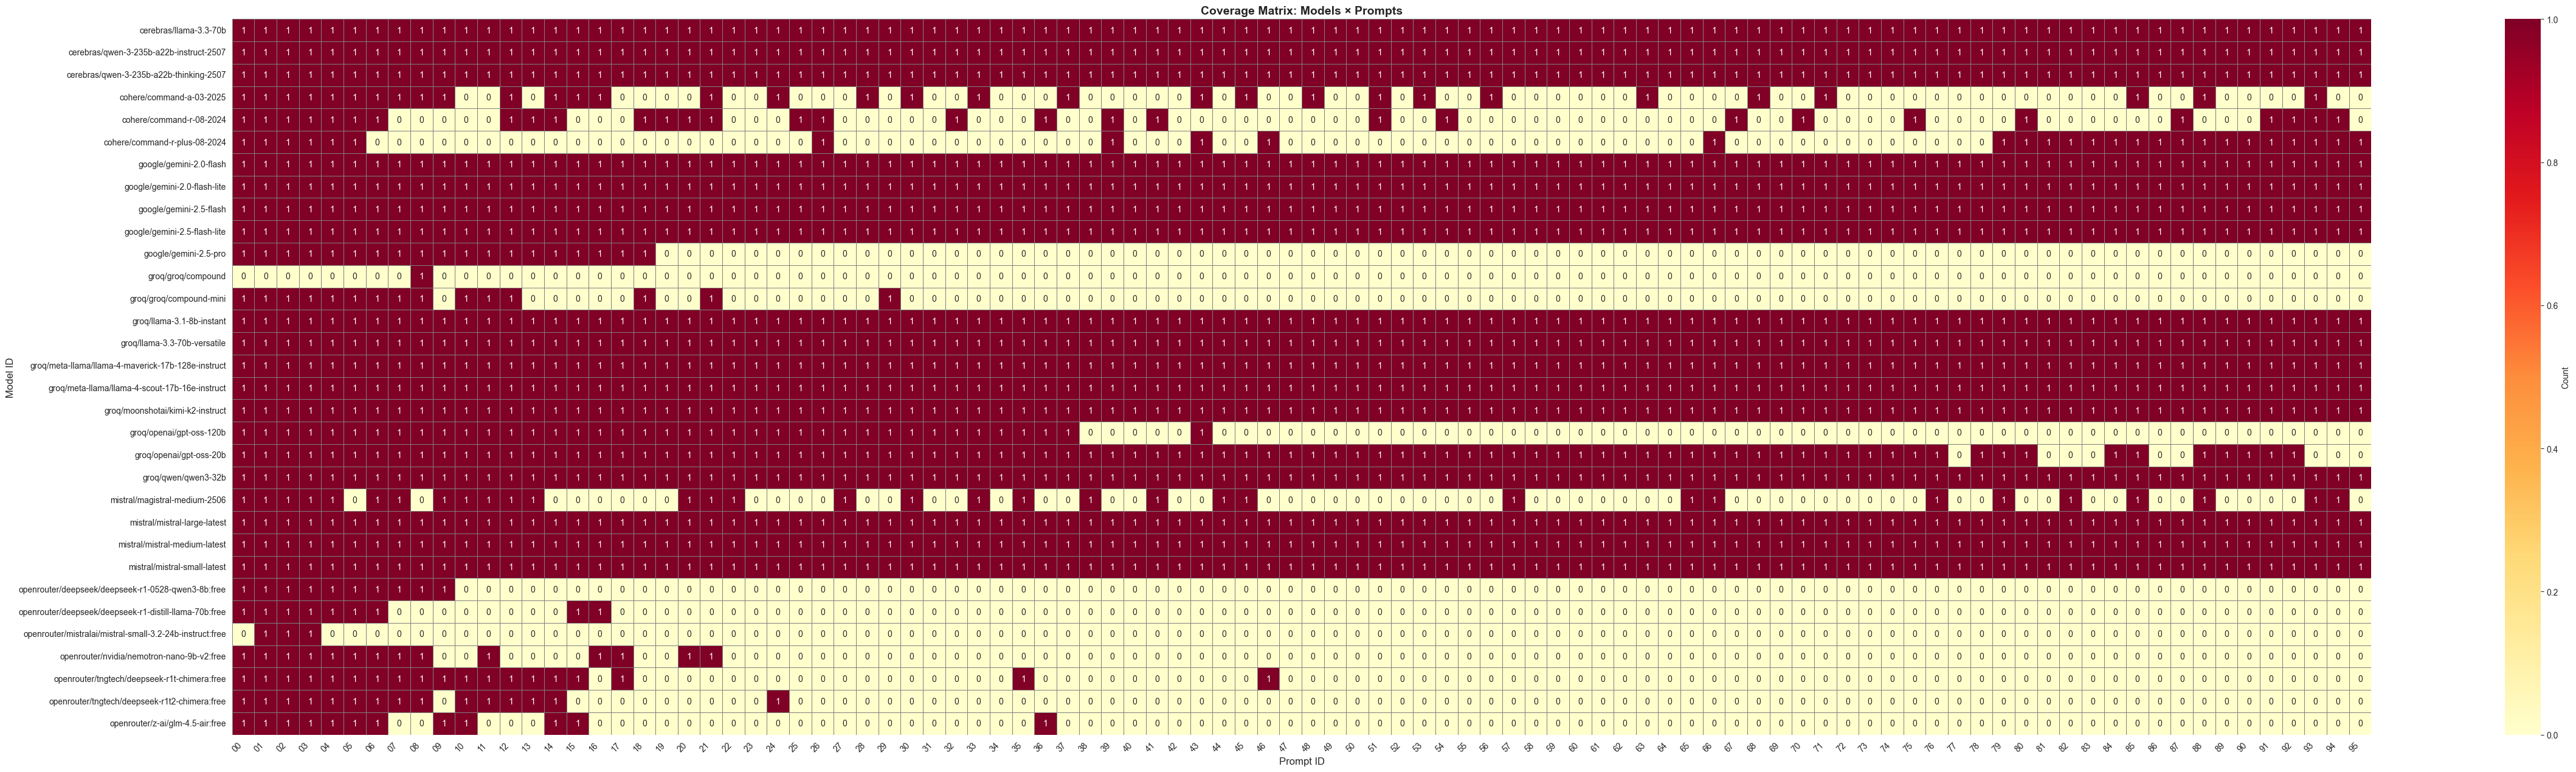

Coverage matrix: 32 models × 96 prompts
Total combinations: 1903
Missing combinations: 1169


In [132]:
# Coverage Heatmap

# Sort coverage matrix for better visualization
coverage_sorted = coverage.sort_index(axis=0).sort_index(axis=1)

plt.figure(figsize=(max(12, len(coverage_sorted.columns) * 0.5), max(6, len(coverage_sorted.index) * 0.4)))
sns.heatmap(
    coverage_sorted,
    annot=True,
    fmt='d',
    cmap='YlOrRd',
    cbar_kws={'label': 'Count'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title("Coverage Matrix: Models × Prompts", fontsize=14, fontweight='bold')
plt.xlabel("Prompt ID", fontsize=12)
plt.ylabel("Model ID", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"Coverage matrix: {coverage_sorted.shape[0]} models × {coverage_sorted.shape[1]} prompts")
print(f"Total combinations: {coverage_sorted.sum().sum()}")
print(f"Missing combinations: {(coverage_sorted == 0).sum().sum()}")


In [133]:
# Missing Data Analysis

# Get all expected combinations
all_prompt_ids = set(df_grid['prompt_id'].unique())
all_model_ids = set(df_success['model_id'].unique())
expected = set(itertools.product(all_prompt_ids, all_model_ids))

# Get actual combinations
actual = set(zip(df_success['prompt_id'], df_success['model_id']))

# Find missing
missing = expected - actual

if missing:
    missing_list = list(missing)
    missing_df = pd.DataFrame(missing_list, columns=['prompt_id', 'model_id'])
    
    # Merge with grid data to get factor information
    missing_df = missing_df.merge(
        df_grid[['prompt_id', 'factors']],
        on='prompt_id',
        how='left'
    )
    
    # Extract perspective and justification from factors
    def extract_missing_info(row):
        factors = row.get('factors', {}) or {}
        return pd.Series({
            'perspective': factors.get('perspective'),
            'justification': factors.get('justification'),
            'relationship_quality': factors.get('relationship_quality'),
        })
    
    missing_info = missing_df.apply(extract_missing_info, axis=1)
    missing_df = pd.concat([missing_df[['prompt_id', 'model_id']], missing_info], axis=1)
    
    print(f"Missing combinations: {len(missing_df)}")
    print("\nFirst 20 missing combinations:")
    print(missing_df.head(20).to_string(index=False))
    
    if len(missing_df) > 20:
        print(f"\n... and {len(missing_df) - 20} more")
else:
    print("✓ No missing combinations - all prompts answered by all models!")


Missing combinations: 1169

First 20 missing combinations:
prompt_id                                                 model_id perspective justification relationship_quality
       52               openrouter/nvidia/nemotron-nano-9b-v2:free    landlord       charity   one_sided_negative
       39                                  groq/groq/compound-mini      tenant economy_tough                  bad
       44                                 cohere/command-r-08-2024    landlord      vacation   one_sided_negative
       76       openrouter/deepseek/deepseek-r1-0528-qwen3-8b:free    landlord      vacation   one_sided_negative
       59                                 groq/openai/gpt-oss-120b      tenant      mercedes   one_sided_positive
       93            openrouter/tngtech/deepseek-r1t2-chimera:free      tenant      mercedes   one_sided_negative
       85                                  groq/groq/compound-mini      tenant       charity   one_sided_negative
       64            openrout

## Completion Statistics


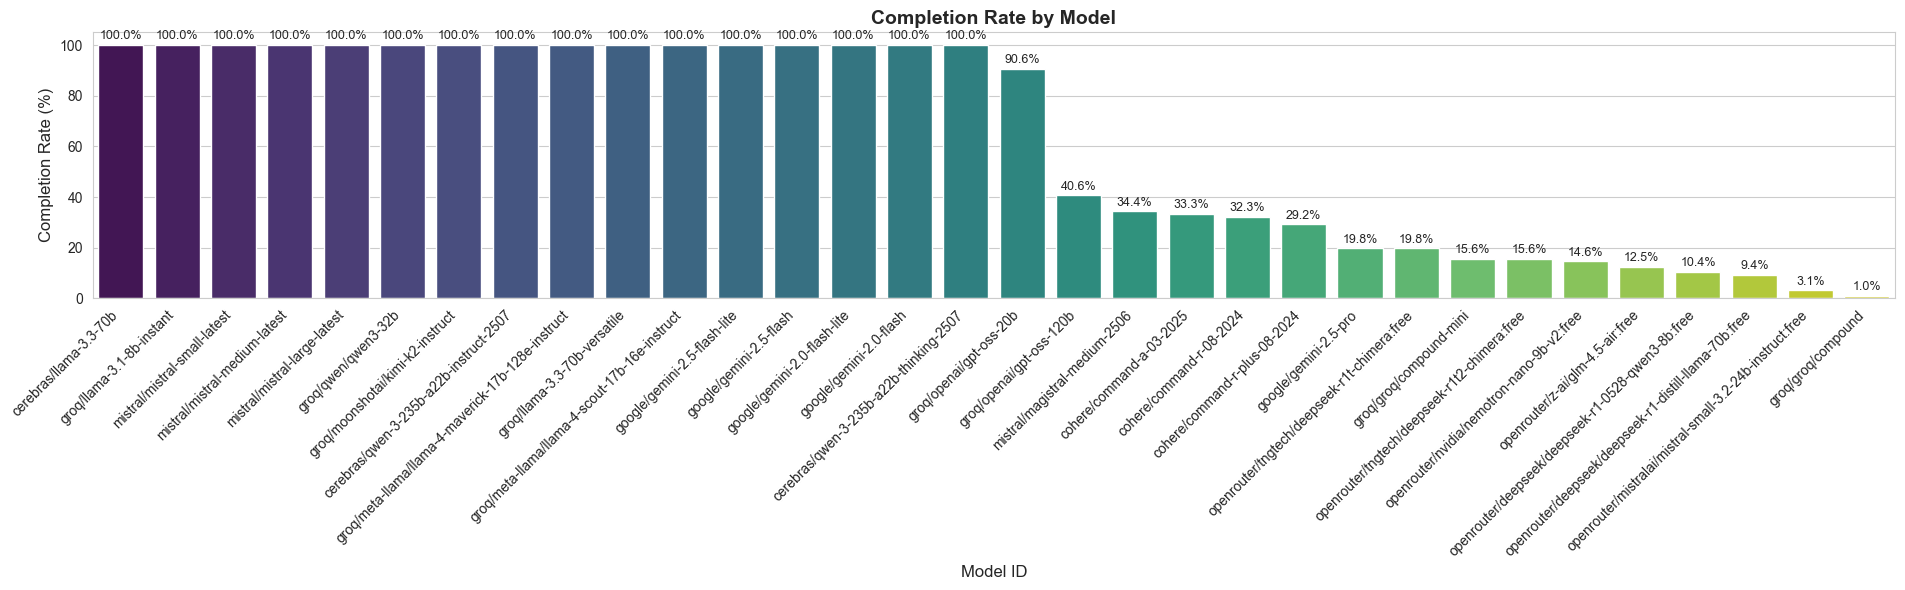

In [134]:
# Completion Rates by Model

plt.figure(figsize=(max(12, len(completion_by_model) * 0.6), 6))
ax = sns.barplot(
    data=completion_by_model,
    x='model_id',
    y='completion_rate',
    palette='viridis'
)
plt.title("Completion Rate by Model", fontsize=14, fontweight='bold')
plt.xlabel("Model ID", fontsize=12)
plt.ylabel("Completion Rate (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 105)

# Add percentage labels on bars
for i, (idx, row) in enumerate(completion_by_model.iterrows()):
    ax.text(i, row['completion_rate'] + 1, f"{row['completion_rate']:.1f}%",
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


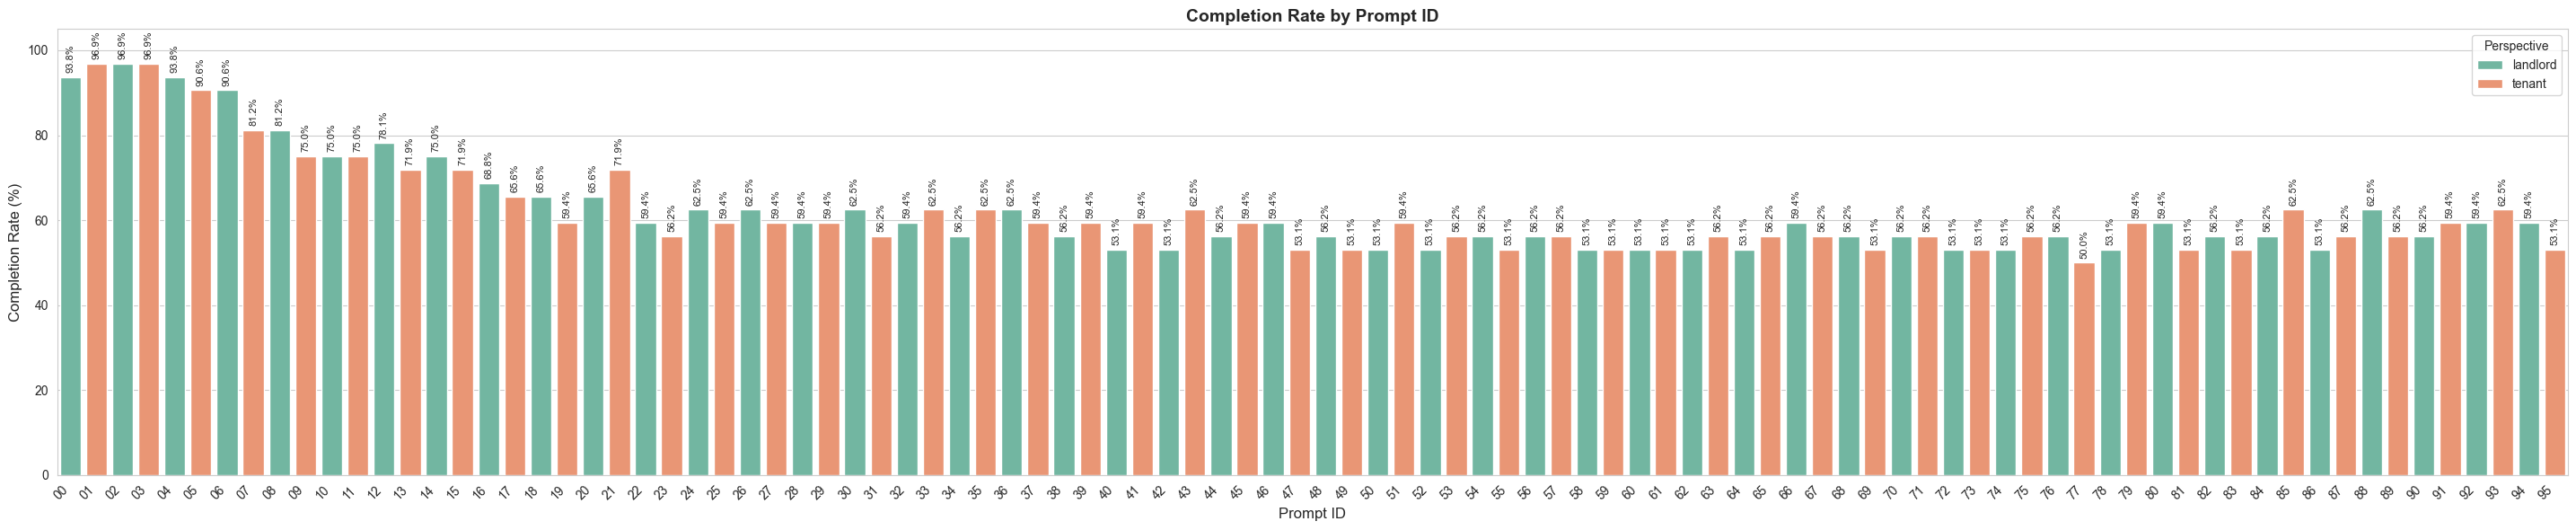

In [135]:
# Completion Rates by Prompt

# Merge with grid to get perspective for coloring
completion_by_prompt = completion_by_prompt.merge(
    df_grid[['prompt_id', 'factors']],
    on='prompt_id',
    how='left'
)
completion_by_prompt['perspective'] = completion_by_prompt['factors'].apply(
    lambda x: x.get('perspective') if isinstance(x, dict) else None
)

plt.figure(figsize=(max(12, len(completion_by_prompt) * 0.3), 6))
ax = sns.barplot(
    data=completion_by_prompt,
    x='prompt_id',
    y='completion_rate',
    hue='perspective',
    palette='Set2'
)
plt.title("Completion Rate by Prompt ID", fontsize=14, fontweight='bold')
plt.xlabel("Prompt ID", fontsize=12)
plt.ylabel("Completion Rate (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 105)
plt.legend(title='Perspective', loc='upper right')

# Add percentage labels on bars
for i, (idx, row) in enumerate(completion_by_prompt.iterrows()):
    ax.text(i, row['completion_rate'] + 1, f"{row['completion_rate']:.1f}%",
            ha='center', va='bottom', fontsize=8, rotation=90)

plt.tight_layout()
plt.show()


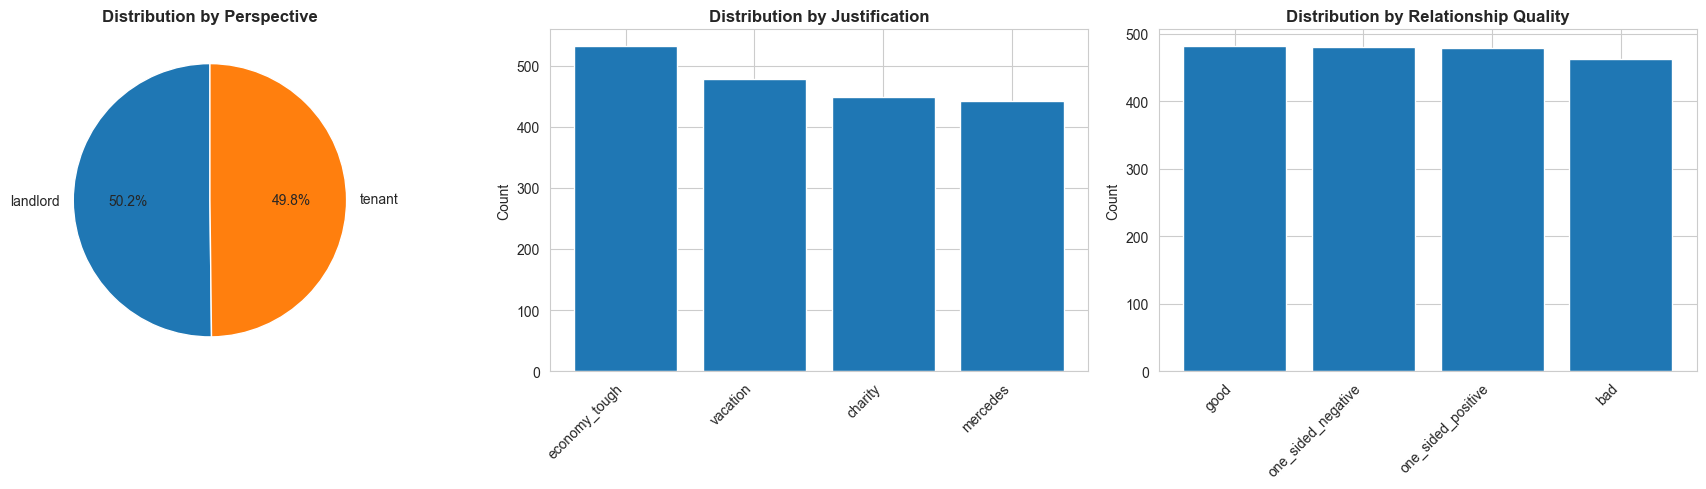

Perspective distribution:
perspective
landlord    955
tenant      948
Name: count, dtype: int64

Justification distribution:
justification
economy_tough    533
vacation         478
charity          449
mercedes         443
Name: count, dtype: int64

Relationship quality distribution:
relationship_quality
good                  482
one_sided_negative    480
one_sided_positive    478
bad                   463
Name: count, dtype: int64


In [136]:
# Distribution by Factors

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Perspective distribution
if 'perspective' in df_success.columns:
    # Ensure 1D by extracting scalar values
    perspective_series = df_success['perspective'].apply(
        lambda x: x.iloc[0] if isinstance(x, pd.Series) 
        else (x[0] if isinstance(x, (list, tuple)) and len(x) > 0
        else (x if isinstance(x, (str, int, float, type(None))) else None))
    )
    perspective_counts = perspective_series.dropna().value_counts()
    if len(perspective_counts) > 0:
        axes[0].pie(perspective_counts.values, labels=perspective_counts.index, autopct='%1.1f%%', startangle=90)
        axes[0].set_title("Distribution by Perspective", fontsize=12, fontweight='bold')
    else:
        axes[0].text(0.5, 0.5, 'No data', ha='center', va='center')
        axes[0].set_title("Distribution by Perspective", fontsize=12, fontweight='bold')
else:
    axes[0].text(0.5, 0.5, 'No perspective data', ha='center', va='center')
    axes[0].set_title("Distribution by Perspective", fontsize=12, fontweight='bold')

# Justification distribution
if 'justification' in df_success.columns:
    justification_series = df_success['justification'].apply(
        lambda x: x.iloc[0] if isinstance(x, pd.Series) 
        else (x[0] if isinstance(x, (list, tuple)) and len(x) > 0
        else (x if isinstance(x, (str, int, float, type(None))) else None))
    )
    justification_counts = justification_series.dropna().value_counts()
    if len(justification_counts) > 0:
        axes[1].bar(range(len(justification_counts)), justification_counts.values)
        axes[1].set_xticks(range(len(justification_counts)))
        axes[1].set_xticklabels(justification_counts.index, rotation=45, ha='right')
        axes[1].set_title("Distribution by Justification", fontsize=12, fontweight='bold')
        axes[1].set_ylabel("Count")
    else:
        axes[1].text(0.5, 0.5, 'No data', ha='center', va='center')
        axes[1].set_title("Distribution by Justification", fontsize=12, fontweight='bold')
else:
    axes[1].text(0.5, 0.5, 'No justification data', ha='center', va='center')
    axes[1].set_title("Distribution by Justification", fontsize=12, fontweight='bold')

# Relationship quality distribution
if 'relationship_quality' in df_success.columns:
    rel_quality_series = df_success['relationship_quality'].apply(
        lambda x: x.iloc[0] if isinstance(x, pd.Series) 
        else (x[0] if isinstance(x, (list, tuple)) and len(x) > 0
        else (x if isinstance(x, (str, int, float, type(None))) else None))
    )
    rel_quality_counts = rel_quality_series.dropna().value_counts()
    if len(rel_quality_counts) > 0:
        axes[2].bar(range(len(rel_quality_counts)), rel_quality_counts.values)
        axes[2].set_xticks(range(len(rel_quality_counts)))
        axes[2].set_xticklabels(rel_quality_counts.index, rotation=45, ha='right')
        axes[2].set_title("Distribution by Relationship Quality", fontsize=12, fontweight='bold')
        axes[2].set_ylabel("Count")
    else:
        axes[2].text(0.5, 0.5, 'No data', ha='center', va='center')
        axes[2].set_title("Distribution by Relationship Quality", fontsize=12, fontweight='bold')
else:
    axes[2].text(0.5, 0.5, 'No relationship quality data', ha='center', va='center')
    axes[2].set_title("Distribution by Relationship Quality", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Print statistics
print("Perspective distribution:")
if 'perspective' in df_success.columns and 'perspective_counts' in locals() and len(perspective_counts) > 0:
    print(perspective_counts)
else:
    print("No perspective data available")

print("\nJustification distribution:")
if 'justification' in df_success.columns and 'justification_counts' in locals() and len(justification_counts) > 0:
    print(justification_counts)
else:
    print("No justification data available")

print("\nRelationship quality distribution:")
if 'relationship_quality' in df_success.columns and 'rel_quality_counts' in locals() and len(rel_quality_counts) > 0:
    print(rel_quality_counts)
else:
    print("No relationship quality data available")


## Performance Metrics


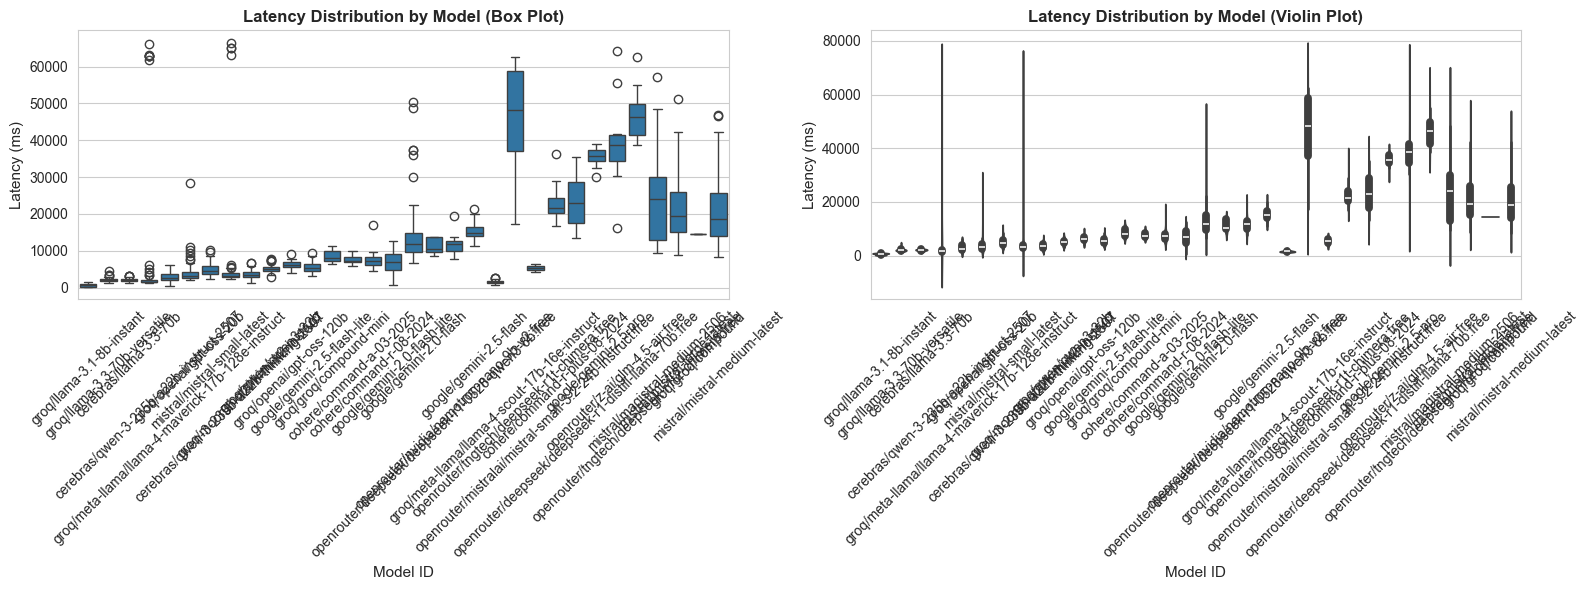

Latency Statistics by Model:
                                                              Mean   Median       Std    Min    Max  Count
model_id                                                                                                  
cerebras/llama-3.3-70b                                     2104.06   2100.5    452.51   1193   3196     96
cerebras/qwen-3-235b-a22b-instruct-2507                    6318.74   1567.5  16076.16   1150  66068     96
cerebras/qwen-3-235b-a22b-thinking-2507                    5980.53   3214.5  12391.73   2382  66516     96
cohere/command-a-03-2025                                   7539.94   7364.0   1028.98   5970  10045     32
cohere/command-r-08-2024                                   7392.65   7161.0   2288.16   4518  16963     31
cohere/command-r-plus-08-2024                             22559.39  21645.0   3757.53  16828  36251     28
google/gemini-2.0-flash                                   14091.82  11907.5   7839.84   6563  50392     96
google/g

In [137]:
# Latency Analysis

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot
sns.boxplot(data=df_success, x='model_id', y='latency_ms', ax=axes[0])
axes[0].set_title("Latency Distribution by Model (Box Plot)", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Model ID", fontsize=11)
axes[0].set_ylabel("Latency (ms)", fontsize=11)
axes[0].tick_params(axis='x', rotation=45)

# Violin plot
sns.violinplot(data=df_success, x='model_id', y='latency_ms', ax=axes[1])
axes[1].set_title("Latency Distribution by Model (Violin Plot)", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Model ID", fontsize=11)
axes[1].set_ylabel("Latency (ms)", fontsize=11)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Summary statistics
latency_stats = df_success.groupby('model_id')['latency_ms'].agg([
    'mean', 'median', 'std', 'min', 'max', 'count'
]).round(2)
latency_stats.columns = ['Mean', 'Median', 'Std', 'Min', 'Max', 'Count']
print("Latency Statistics by Model:")
print(latency_stats.to_string())


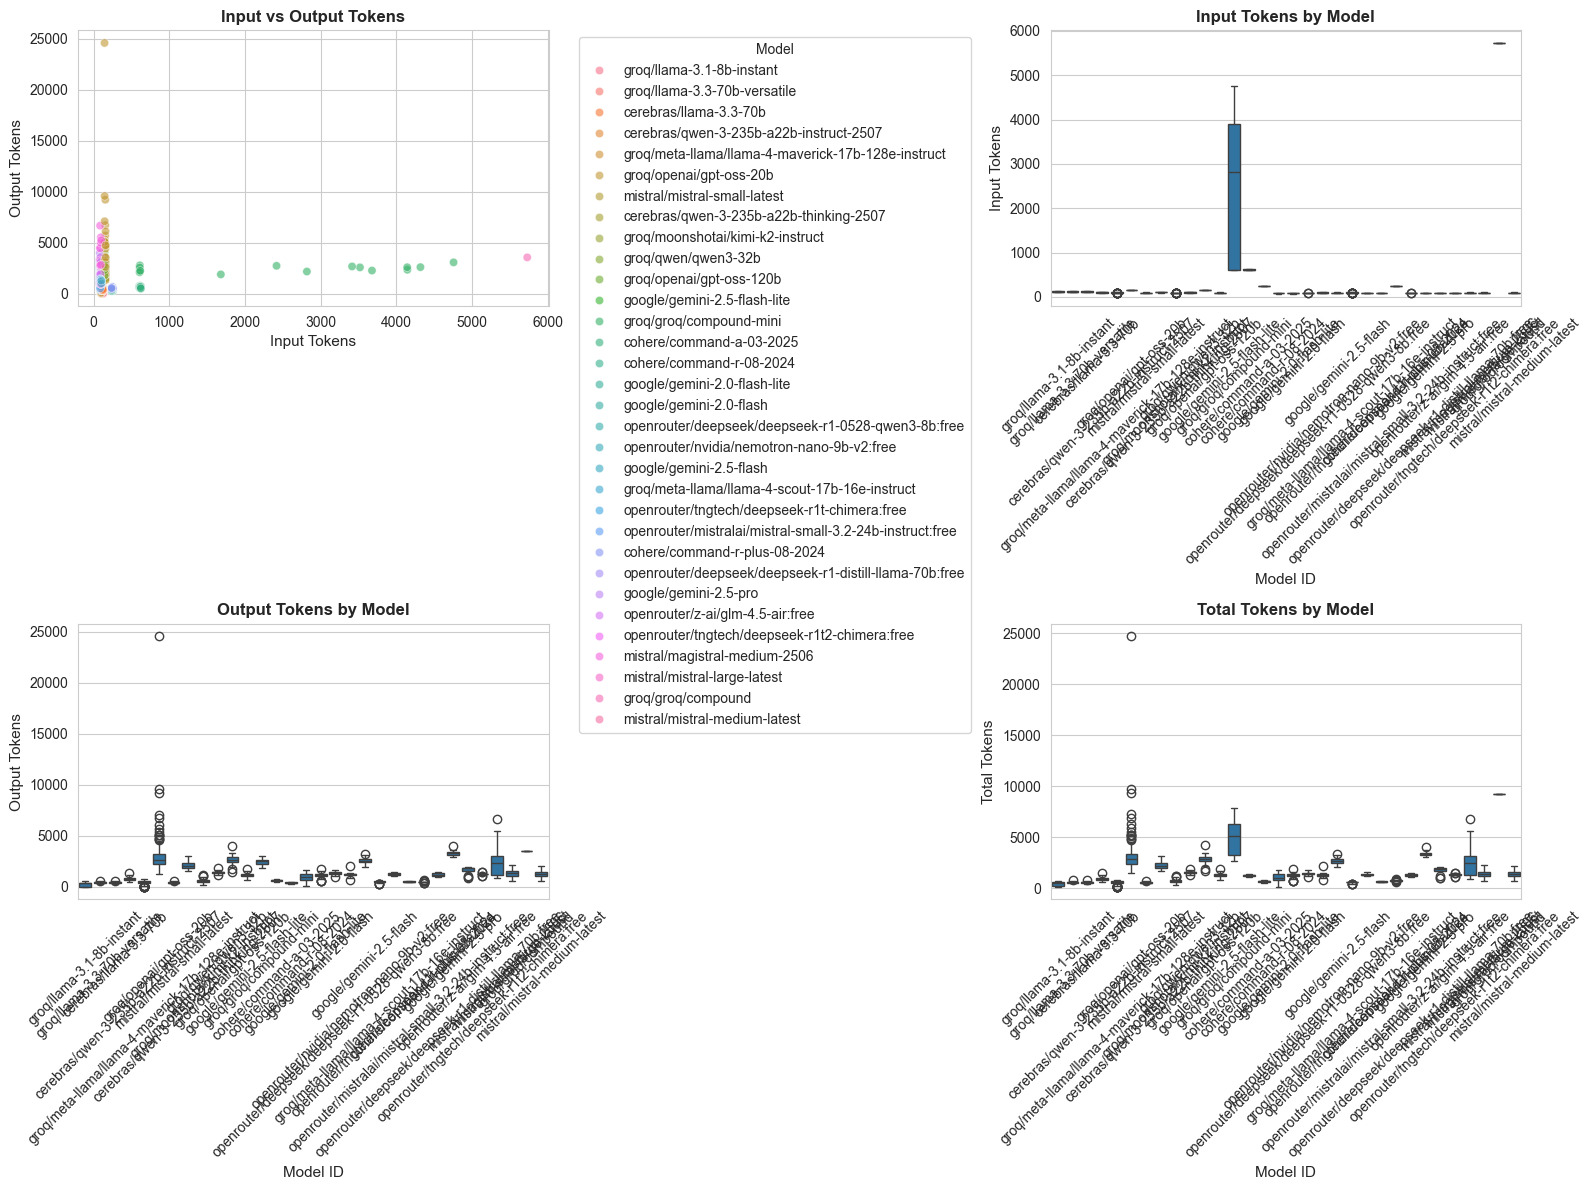

Token Usage Statistics by Model:
                                                         input_tokens                              output_tokens                               total_tokens                              
                                                                 mean  median      std   min   max          mean  median      std   min    max         mean  median      std   min    max
model_id                                                                                                                                                                                 
cerebras/llama-3.3-70b                                         118.88   120.0     5.57   109   126        448.38   454.0    63.56   295    626       567.25   573.5    62.65   420    746
cerebras/qwen-3-235b-a22b-instruct-2507                        100.54   102.0     5.59    90   108        825.41   816.0   164.27   469   1362       925.95   921.0   160.70   576   1453
cerebras/qwen-3-235b-a22b-thinking-25

In [138]:
# Token Usage Analysis

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Scatter plot: input vs output tokens
sns.scatterplot(
    data=df_success,
    x='input_tokens',
    y='output_tokens',
    hue='model_id',
    ax=axes[0, 0],
    alpha=0.6
)
axes[0, 0].set_title("Input vs Output Tokens", fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel("Input Tokens", fontsize=11)
axes[0, 0].set_ylabel("Output Tokens", fontsize=11)
axes[0, 0].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# Box plot: input tokens
sns.boxplot(data=df_success, x='model_id', y='input_tokens', ax=axes[0, 1])
axes[0, 1].set_title("Input Tokens by Model", fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel("Model ID", fontsize=11)
axes[0, 1].set_ylabel("Input Tokens", fontsize=11)
axes[0, 1].tick_params(axis='x', rotation=45)

# Box plot: output tokens
sns.boxplot(data=df_success, x='model_id', y='output_tokens', ax=axes[1, 0])
axes[1, 0].set_title("Output Tokens by Model", fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel("Model ID", fontsize=11)
axes[1, 0].set_ylabel("Output Tokens", fontsize=11)
axes[1, 0].tick_params(axis='x', rotation=45)

# Box plot: total tokens
sns.boxplot(data=df_success, x='model_id', y='total_tokens', ax=axes[1, 1])
axes[1, 1].set_title("Total Tokens by Model", fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel("Model ID", fontsize=11)
axes[1, 1].set_ylabel("Total Tokens", fontsize=11)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Summary statistics
token_stats = df_success.groupby('model_id')[['input_tokens', 'output_tokens', 'total_tokens']].agg([
    'mean', 'median', 'std', 'min', 'max'
]).round(2)
print("Token Usage Statistics by Model:")
print(token_stats.to_string())


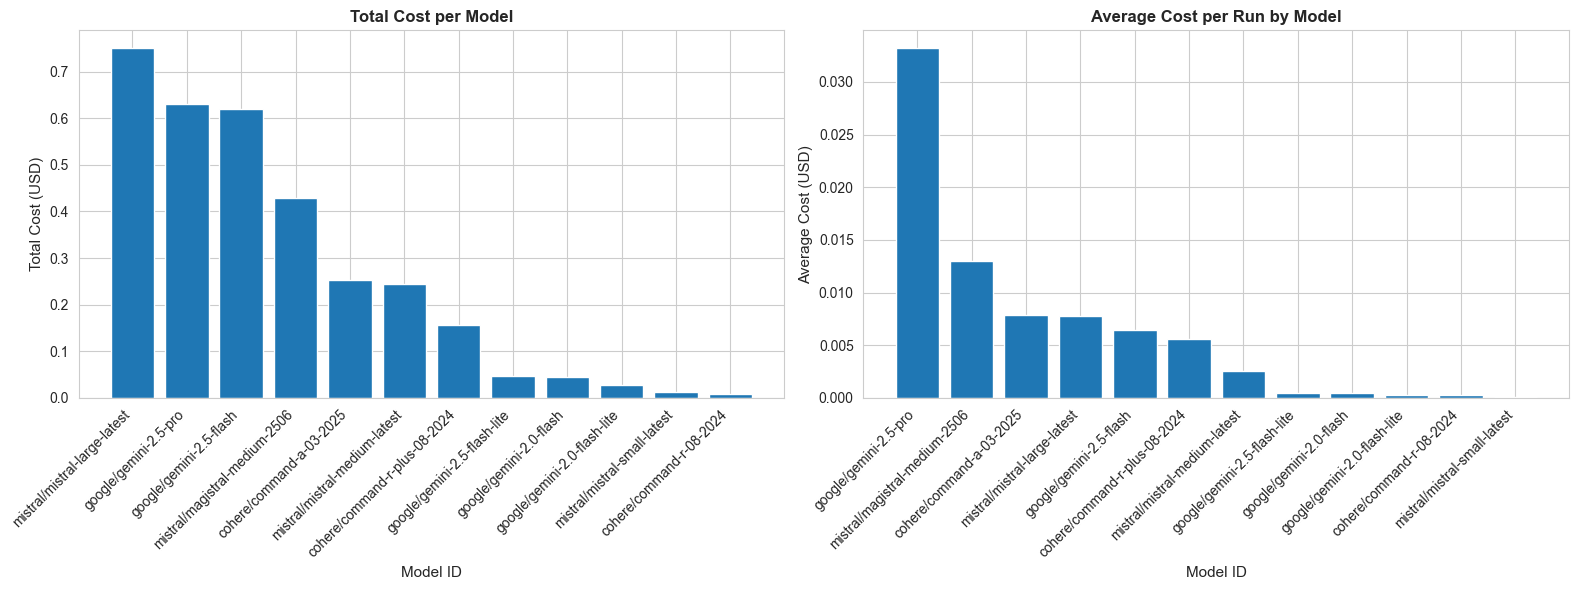

Cost Statistics by Model:
                               Total Cost (USD)  Avg Cost per Run (USD)  Runs with Cost  Cost per 1K Tokens
model_id                                                                                                   
cohere/command-a-03-2025                 0.2531                  0.0079              32              0.0063
cohere/command-r-08-2024                 0.0086                  0.0003              31              0.0004
cohere/command-r-plus-08-2024            0.1556                  0.0056              28              0.0075
google/gemini-2.0-flash                  0.0454                  0.0005              96              0.0004
google/gemini-2.0-flash-lite             0.0286                  0.0003              96              0.0003
google/gemini-2.5-flash                  0.6203                  0.0065              96              0.0024
google/gemini-2.5-flash-lite             0.0465                  0.0005              96              0.0004
go

In [139]:
# Cost Analysis

df_with_cost = df_success[df_success['cost_usd'].notna()].copy()

if len(df_with_cost) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Total cost per model
    total_cost = df_with_cost.groupby('model_id')['cost_usd'].sum().sort_values(ascending=False)
    axes[0].bar(range(len(total_cost)), total_cost.values)
    axes[0].set_xticks(range(len(total_cost)))
    axes[0].set_xticklabels(total_cost.index, rotation=45, ha='right')
    axes[0].set_title("Total Cost per Model", fontsize=12, fontweight='bold')
    axes[0].set_xlabel("Model ID", fontsize=11)
    axes[0].set_ylabel("Total Cost (USD)", fontsize=11)
    
    # Average cost per prompt per model
    avg_cost = df_with_cost.groupby('model_id')['cost_usd'].mean().sort_values(ascending=False)
    axes[1].bar(range(len(avg_cost)), avg_cost.values)
    axes[1].set_xticks(range(len(avg_cost)))
    axes[1].set_xticklabels(avg_cost.index, rotation=45, ha='right')
    axes[1].set_title("Average Cost per Run by Model", fontsize=12, fontweight='bold')
    axes[1].set_xlabel("Model ID", fontsize=11)
    axes[1].set_ylabel("Average Cost (USD)", fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # Summary table
    cost_summary = df_with_cost.groupby('model_id').agg({
        'cost_usd': ['sum', 'mean', 'count']
    }).round(4)
    cost_summary.columns = ['Total Cost (USD)', 'Avg Cost per Run (USD)', 'Runs with Cost']
    
    # Calculate cost per 1K tokens
    cost_summary['Cost per 1K Tokens'] = (
        (df_with_cost.groupby('model_id')['cost_usd'].sum() / 
         df_with_cost.groupby('model_id')['total_tokens'].sum() * 1000)
    ).round(4)
    
    print("Cost Statistics by Model:")
    print(cost_summary.to_string())
else:
    print("No cost data available in the dataset.")


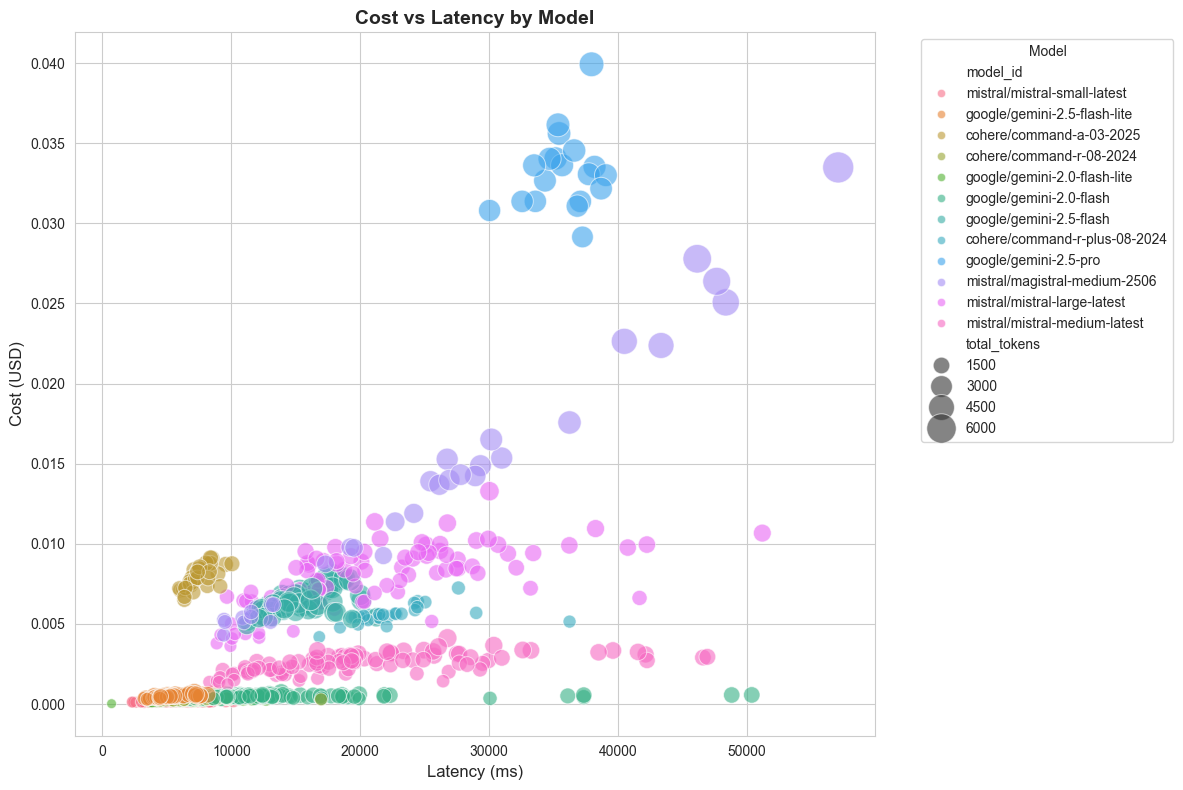

In [140]:
# Cost vs Latency Scatter

df_plot = df_success.copy()
df_plot = df_plot[df_plot['cost_usd'].notna()] if df_plot['cost_usd'].notna().any() else df_plot

if len(df_plot) > 0 and df_plot['cost_usd'].notna().any():
    # Static seaborn plot
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=df_plot,
        x='latency_ms',
        y='cost_usd',
        hue='model_id',
        size='total_tokens',
        sizes=(50, 500),
        alpha=0.6
    )
    plt.title("Cost vs Latency by Model", fontsize=14, fontweight='bold')
    plt.xlabel("Latency (ms)", fontsize=12)
    plt.ylabel("Cost (USD)", fontsize=12)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Interactive plotly version (if available)
    fig = px.scatter(
        df_plot,
        x='latency_ms',
        y='cost_usd',
        color='model_id',
        size='total_tokens',
        hover_data=['prompt_id', 'provider', 'input_tokens', 'output_tokens'],
        title="Cost vs Latency by Model (Interactive)",
        labels={'latency_ms': 'Latency (ms)', 'cost_usd': 'Cost (USD)'}
    )
    fig.update_layout(height=600)
    fig.show()
else:
    print("No cost data available for scatter plot.")


## Time-Based Analysis


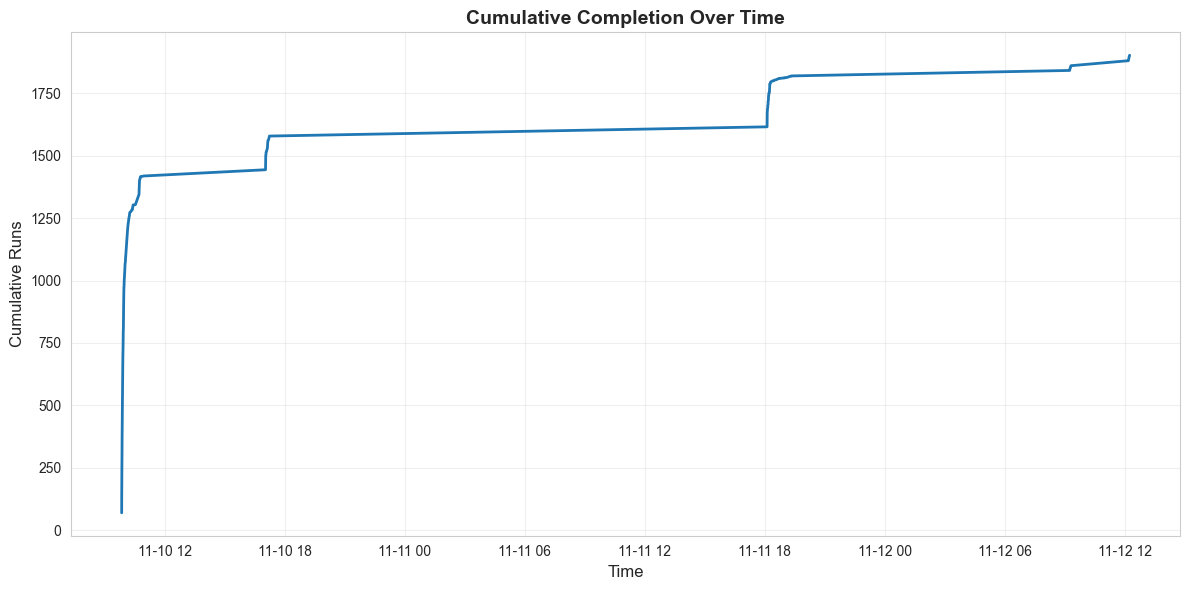

In [141]:
# Run Progression

# Time series by hour
df_time = df_success.groupby([pd.Grouper(key='timestamp', freq='H'), 'model_id']).size().reset_index()
df_time.columns = ['timestamp', 'model_id', 'count']

# Interactive plotly line chart (if available)
fig = px.line(
    df_time,
    x='timestamp',
    y='count',
    color='model_id',
    title="Run Progression Over Time (by Hour)",
    labels={'count': 'Number of Runs', 'timestamp': 'Time'}
)
fig.update_layout(height=500)
fig.show()


# Cumulative completion
cumulative = df_success.groupby('timestamp').size().cumsum()
plt.figure(figsize=(12, 6))
plt.plot(cumulative.index, cumulative.values, linewidth=2)
plt.title("Cumulative Completion Over Time", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Cumulative Runs", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


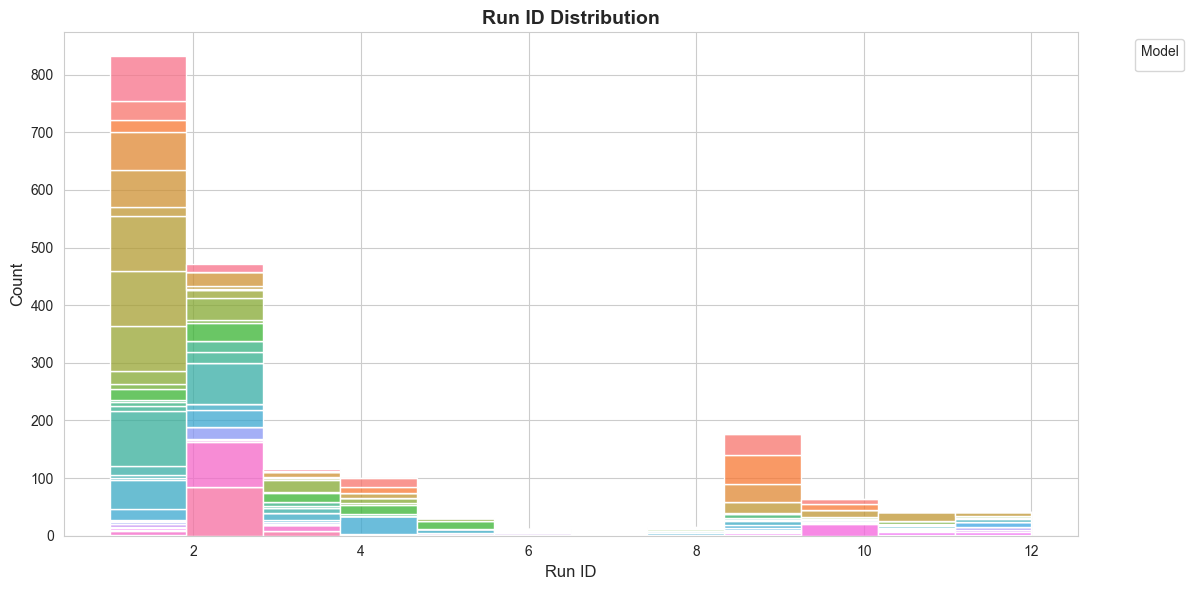

Run ID Statistics:
count    1903.000000
mean        3.189700
std         3.243088
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        12.000000
Name: run_id, dtype: float64

Unique run IDs: 12
Runs per ID distribution:
count     12.000000
mean     158.583333
std      248.019962
min        2.000000
25%       27.000000
50%       53.000000
75%      130.500000
max      832.000000
dtype: float64


In [142]:
# Run ID Distribution

plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_success,
    x='run_id',
    hue='model_id',
    multiple='stack',
    bins=min(50, df_success['run_id'].nunique())
)
plt.title("Run ID Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Run ID", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Statistics
print("Run ID Statistics:")
print(df_success['run_id'].describe())
print(f"\nUnique run IDs: {df_success['run_id'].nunique()}")
print(f"Runs per ID distribution:")
print(df_success.groupby('run_id').size().describe())


## Response Analysis


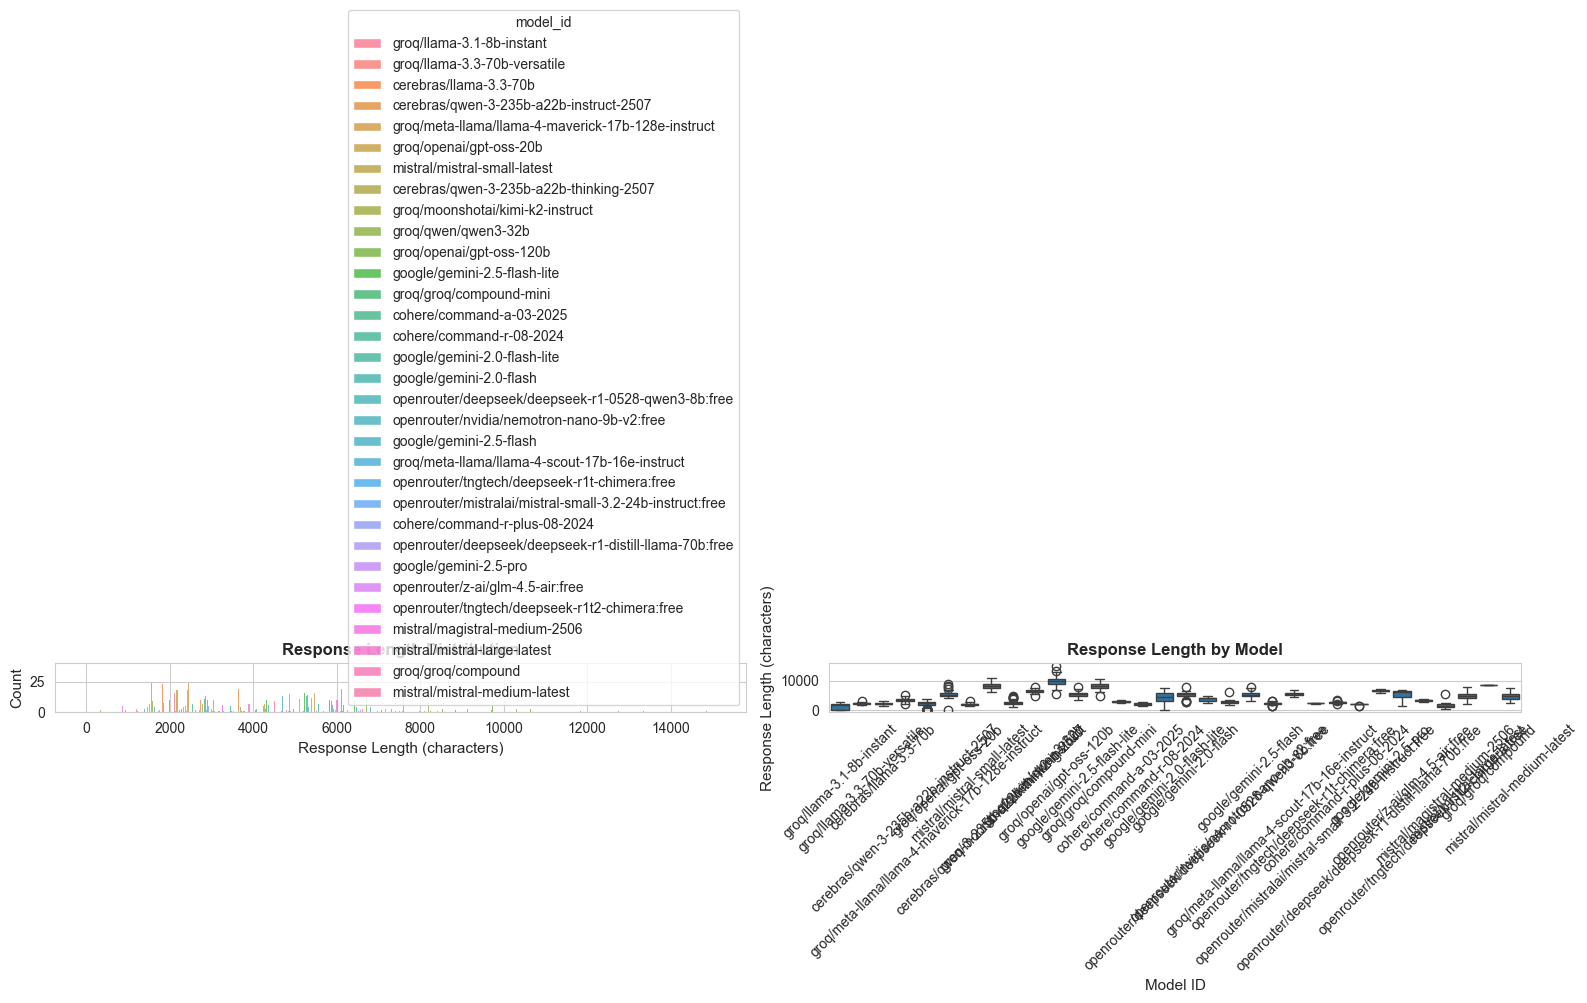

Response Length Statistics by Model:
                                                             Mean  Median      Std   Min    Max  Count
model_id                                                                                              
cerebras/llama-3.3-70b                                    2209.96  2213.0   314.02  1499   2997     96
cerebras/qwen-3-235b-a22b-instruct-2507                   3474.57  3460.0   570.72  2004   5092     96
cerebras/qwen-3-235b-a22b-thinking-2507                   8283.89  8016.5  1201.17  6229  10933     96
cohere/command-a-03-2025                                  2857.78  2793.0   300.72  2277   3441     32
cohere/command-r-08-2024                                  2093.06  2110.0   405.39  1322   2818     31
cohere/command-r-plus-08-2024                             2627.82  2634.0   286.90  1934   3322     28
google/gemini-2.0-flash                                   5245.89  5353.5   858.28  2839   7866     96
google/gemini-2.0-flash-lite        

In [143]:
# Response Length Analysis

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
sns.histplot(
    data=df_success,
    x='response_length',
    hue='model_id',
    multiple='dodge',
    bins=50,
    ax=axes[0]
)
axes[0].set_title("Response Length Distribution", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Response Length (characters)", fontsize=11)
axes[0].set_ylabel("Count", fontsize=11)

# Box plot
sns.boxplot(
    data=df_success,
    x='model_id',
    y='response_length',
    ax=axes[1]
)
axes[1].set_title("Response Length by Model", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Model ID", fontsize=11)
axes[1].set_ylabel("Response Length (characters)", fontsize=11)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Summary statistics
response_stats = df_success.groupby('model_id')['response_length'].agg([
    'mean', 'median', 'std', 'min', 'max', 'count'
]).round(2)
response_stats.columns = ['Mean', 'Median', 'Std', 'Min', 'Max', 'Count']
print("Response Length Statistics by Model:")
print(response_stats.to_string())


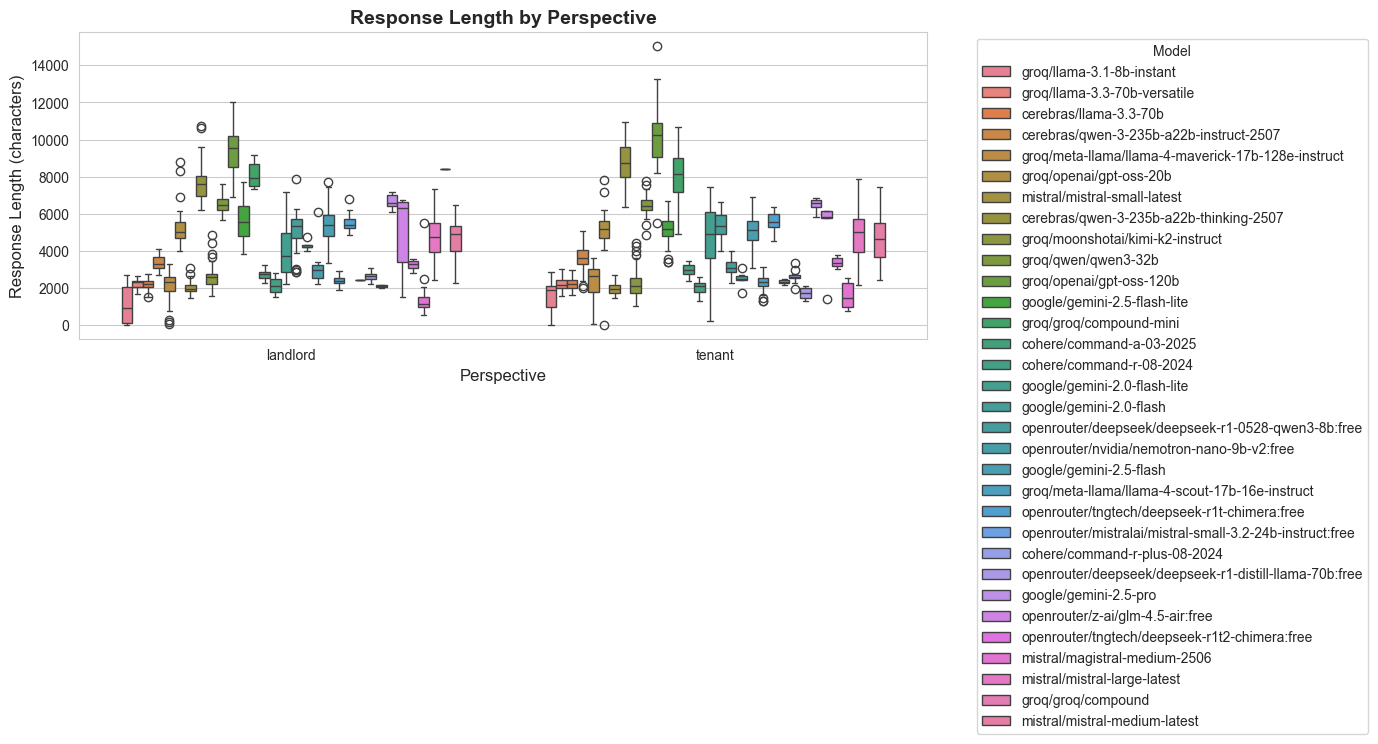

T-test comparing landlord vs tenant response lengths:
  T-statistic: -0.6787
  P-value: 0.4974
  Landlord mean: 4009.64 chars
  Tenant mean: 4078.63 chars


In [144]:
# Response Length by Perspective

plt.figure(figsize=(14, 6))
sns.boxplot(
    data=df_success,
    x='perspective',
    y='response_length',
    hue='model_id'
)
plt.title("Response Length by Perspective", fontsize=14, fontweight='bold')
plt.xlabel("Perspective", fontsize=12)
plt.ylabel("Response Length (characters)", fontsize=12)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Statistical comparison
try:
    from scipy import stats
    
    landlord_lengths = df_success[df_success['perspective'] == 'landlord']['response_length']
    tenant_lengths = df_success[df_success['perspective'] == 'tenant']['response_length']
    
    if len(landlord_lengths) > 0 and len(tenant_lengths) > 0:
        t_stat, p_value = stats.ttest_ind(landlord_lengths, tenant_lengths)
        print(f"T-test comparing landlord vs tenant response lengths:")
        print(f"  T-statistic: {t_stat:.4f}")
        print(f"  P-value: {p_value:.4f}")
        print(f"  Landlord mean: {landlord_lengths.mean():.2f} chars")
        print(f"  Tenant mean: {tenant_lengths.mean():.2f} chars")
except ImportError:
    print("scipy not available - skipping statistical test")
    landlord_lengths = df_success[df_success['perspective'] == 'landlord']['response_length']
    tenant_lengths = df_success[df_success['perspective'] == 'tenant']['response_length']
    if len(landlord_lengths) > 0 and len(tenant_lengths) > 0:
        print(f"  Landlord mean: {landlord_lengths.mean():.2f} chars")
        print(f"  Tenant mean: {tenant_lengths.mean():.2f} chars")


## Interactive Dashboard


In [145]:
# Interactive Coverage Explorer

# Create interactive heatmap with plotly (if available)
coverage_for_plotly = coverage_sorted.copy()

fig = go.Figure(data=go.Heatmap(
    z=coverage_for_plotly.values,
    x=coverage_for_plotly.columns,
    y=coverage_for_plotly.index,
    colorscale='YlOrRd',
    text=coverage_for_plotly.values,
    texttemplate='%{text}',
    textfont={"size": 10},
    hovertemplate='<b>Model:</b> %{y}<br>' +
                    '<b>Prompt:</b> %{x}<br>' +
                    '<b>Count:</b> %{z}<br>' +
                    '<extra></extra>',
    colorbar=dict(title="Count")
))

fig.update_layout(
    title="Interactive Coverage Matrix: Models × Prompts",
    xaxis_title="Prompt ID",
    yaxis_title="Model ID",
    height=max(400, len(coverage_for_plotly.index) * 30),
    width=max(800, len(coverage_for_plotly.columns) * 40)
)

fig.show()

## Summary and Export


In [146]:
# Summary Statistics

# Per model summary
model_summary = df_success.groupby('model_id').agg({
    'prompt_id': 'nunique',
    'latency_ms': ['mean', 'median'],
    'total_tokens': ['mean', 'sum'],
    'cost_usd': ['sum', 'mean'],
    'response_length': 'mean'
}).round(2)

model_summary.columns = [
    'Prompts_Answered',
    'Avg_Latency_ms',
    'Median_Latency_ms',
    'Avg_Tokens',
    'Total_Tokens',
    'Total_Cost_USD',
    'Avg_Cost_USD',
    'Avg_Response_Length'
]

# Add completion rate
model_summary['Completion_Rate_%'] = (model_summary['Prompts_Answered'] / total_prompts * 100).round(1)

# Per prompt summary
prompt_summary = df_success.groupby('prompt_id').agg({
    'model_id': 'nunique',
    'response_length': 'mean',
    'latency_ms': 'mean',
    'total_tokens': 'mean'
}).round(2)

prompt_summary.columns = [
    'Models_Answered',
    'Avg_Response_Length',
    'Avg_Latency_ms',
    'Avg_Tokens'
]

# Add completion rate
prompt_summary['Completion_Rate_%'] = (prompt_summary['Models_Answered'] / unique_models * 100).round(1)

print("=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)
print("\nPer Model Summary:")
print(model_summary.to_string())
print("\nPer Prompt Summary:")
print(prompt_summary.head(20).to_string())
if len(prompt_summary) > 20:
    print(f"\n... and {len(prompt_summary) - 20} more prompts")

# Export to CSV
model_summary.to_csv(run_dir / 'analysis_summary_models.csv')
prompt_summary.to_csv(run_dir / 'analysis_summary_prompts.csv')
print(f"\n✓ Exported summaries to:")
print(f"  - {run_dir / 'analysis_summary_models.csv'}")
print(f"  - {run_dir / 'analysis_summary_prompts.csv'}")


SUMMARY STATISTICS

Per Model Summary:
                                                          Prompts_Answered  Avg_Latency_ms  Median_Latency_ms  Avg_Tokens  Total_Tokens  Total_Cost_USD  Avg_Cost_USD  Avg_Response_Length  Completion_Rate_%
model_id                                                                                                                                                                                                     
cerebras/llama-3.3-70b                                                  96         2104.06             2100.5      567.25         54456            0.00           NaN              2209.96              100.0
cerebras/qwen-3-235b-a22b-instruct-2507                                 96         6318.74             1567.5      925.95         88891            0.00           NaN              3474.57              100.0
cerebras/qwen-3-235b-a22b-thinking-2507                                 96         5980.53             3214.5     2243.78        215403  

In [147]:
# Export Visualizations

# Save coverage heatmap
plt.figure(figsize=(max(12, len(coverage_sorted.columns) * 0.5), max(6, len(coverage_sorted.index) * 0.4)))
sns.heatmap(
    coverage_sorted,
    annot=True,
    fmt='d',
    cmap='YlOrRd',
    cbar_kws={'label': 'Count'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title("Coverage Matrix: Models × Prompts", fontsize=14, fontweight='bold')
plt.xlabel("Prompt ID", fontsize=12)
plt.ylabel("Model ID", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(run_dir / 'coverage_heatmap.png', dpi=300, bbox_inches='tight')
plt.close()

# Save iteractive coverage as HTML (if plotly available)
coverage_for_plotly = coverage_sorted.copy()
fig = go.Figure(data=go.Heatmap(
    z=coverage_for_plotly.values,
    x=coverage_for_plotly.columns,
    y=coverage_for_plotly.index,
    colorscale='YlOrRd',
    text=coverage_for_plotly.values,
    texttemplate='%{text}',
    textfont={"size": 10},
    hovertemplate='<b>Model:</b> %{y}<br>' +
                    '<b>Prompt:</b> %{x}<br>' +
                    '<b>Count:</b> %{z}<br>' +
                    '<extra></extra>',
    colorbar=dict(title="Count")
))
fig.update_layout(
    title="Interactive Coverage Matrix: Models × Prompts",
    xaxis_title="Prompt ID",
    yaxis_title="Model ID",
    height=max(400, len(coverage_for_plotly.index) * 30),
    width=max(800, len(coverage_for_plotly.columns) * 40)
)
fig.write_html(run_dir / 'interactive_coverage.html')
